<a href="https://colab.research.google.com/github/Kaustubh-20/ML_Practice/blob/main/Questions_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
import nltk
import heapq
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')
sns.set_context('notebook')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1. Import Dataset**

In [ ]:
df_questions = pd.read_csv("/content/Questions.csv", nrows=5000, usecols=['Score', 'Title', 'Body'], encoding='latin1')
df_questions = df_questions.dropna()
df_questions.head(15)

,Score,Title,Body
0,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,79,Automatically update version number,<p>I would like the version property of my app...
9,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


**2. Text preprocessing**

There is some HTML tag and different code syntax. I need to remove those because those codes and weird punctuations are not beneficial for this project. I will be using python build in libraries for handling regex and spacy for NLP task.

In this step, I will be using Spacy for preprocessing text, in others words I will clearing not useful features from question title like punctuation, stopwords. For this task, there are two useful libraries available in Python. 1. NLTK 2. Spacy. In this notebook, I will be working with Spacy because it is very fast and has many useful features compared to NLTK.

In [ ]:
!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# in this step we are going to remove code syntax from text
df_questions['Body_Cleaned_1'] = df_questions['Body'].apply(normalize_text)

In [ ]:
print('Before normalizing text::::::::::\n')
print(df_questions['Body'][2])
print('\nAfter normalizing text:::::::::\n')
print(df_questions['Body_Cleaned_1'][2])

Before normalizing text::::::::::

<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>

<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way for the users of my site to create and modify pages dynamically.</p>

<p>I need to tie page viewing permissions into the standard <code>ASP.NET</code> membership system as well.</p>


After normalizing text:::::::::

Has anyone got experience creating SQL-based ASP.NET site-map providers?I've got the default XML file web.sitemap working properly with my Menu and SiteMapPath controls, but I'll need a way for the users of my site to create and modify pages dynamically.I need to tie page viewing permissions into the standard ASP.NET membership system as well.


###We can see a huge difference after normalizing our text. Now we can see our text is more manageable. This will help us to explore the question and later making summarizer.

###We are also seeing that there are some punctuation and stopwords. We also don't need them. In the first place, I don't remove them because we are gonna need this in future when we will make summarizer. So let's make another column that will store our normalized text without punctuation and stopwords.

In [ ]:
# Clean text before feeding it to spaCy
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)


df_questions['Body_Cleaned'] = df_questions['Body_Cleaned_1'].apply(lambda x: cleanup_text(x, False))

In [ ]:
print('Question Body with punctuatin and stopwords:::::::::::\n')
print(df_questions['Body_Cleaned_1'][0])
print('\nQuestion Body after removing punctuation and stopwrods:::::::::::::\n')
print(df_questions['Body_Cleaned'][0])

Question Body with punctuatin and stopwords:::::::::::

I've written a database generation script in SQL and want to execute it in my Adobe AIR application:I execute this in Adobe AIR using the following methods:No errors are generated, however only tRole exists. It seems that it only looks at the first query (up to the semicolon- if I remove it, the query fails). Is there a way to call multiple queries in one statement?

Question Body after removing punctuation and stopwrods:::::::::::::

write database generation script sql want execute adobe air application execute adobe air use follow method error generate however trole exist . seem look first query semicolon- remove query fail . way call multiple query one statement


**3. Distribution of Score**

In this section, I will try understand the distribution of score. Here score mean number of upvote the question got in stackoverflow.

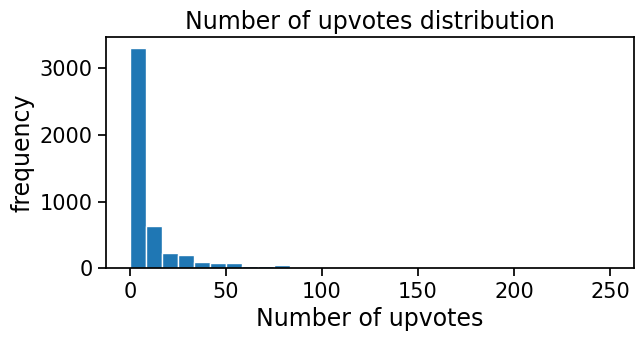

In [ ]:
plt.subplot(1, 2, 1)
(df_questions['Score']).plot.hist(bins=30, figsize=(15,3), edgecolor='white',range=[0,250])
plt.xlabel('Number of upvotes', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Number of upvotes distribution', fontsize=17)
plt.show()

**4. Question Summarizer**

In this step, I will try to make a question summarizer. There is a huge amount of research going for text summarization. But I will try to do a simple technique for text summarization. The technique describes below.

1. Convert Paragraphs to Sentences
We first need to convert the whole paragraph into sentences. The most common way of converting paragraphs to sentences is to split the paragraph whenever a period is encountered.

2. Text Preprocessing
After converting paragraph to sentences, we need to remove all the special characters, stop words and numbers from all the sentences.

3. Tokenizing the Sentences
We need to tokenize all the sentences to get all the words that exist in the sentences

4. Find Weighted Frequency of Occurrence
Next we need to find the weighted frequency of occurrences of all the words. We can find the weighted frequency of each word by dividing its frequency by the frequency of the most occurring word.

5. Replace Words by Weighted Frequency in Original Sentences
The final step is to plug the weighted frequency in place of the corresponding words in original sentences and finding their sum. It is important to mention that weighted frequency for the words removed during preprocessing (stop words, punctuation, digits etc.) will be zero and therefore is not required to be added

6. Sort Sentences in Descending Order of Sum
The final step is to sort the sentences in inverse order of their sum. The sentences with highest frequencies summarize the text.

In [ ]:
# this is function for text summarization

def generate_summary(text_without_removing_dot, cleaned_text):
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}
    for word in nltk.word_tokenize(cleaned_text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1


    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)


    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    print("Original Text::::::::::::\n")
    print(text_without_removing_dot)
    print('\n\nSummarized text::::::::\n')
    print(summary)

Now we have written the function let's try to summarize some questions.

In [ ]:
import nltk
nltk.download('punkt')
generate_summary(df_questions['Body_Cleaned_1'][3], df_questions['Body_Cleaned'][3])

Original Text::::::::::::

This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate N colors, that are as distinguishable as possible where N is a parameter.


Summarized text::::::::

The problem is to come up with a way to generate N colors that are as distinguishable as possible where N is a parameter This is something Ive pseudosolved many times and never quite found a solution Thats stuck with me


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
generate_summary(df_questions['Body_Cleaned_1'][5], df_questions['Body_Cleaned'][5])

Original Text::::::::::::

I am working on a collection of classes used for video playback and recording. I have one main class which acts like the public interface, with methods like play(), stop(), pause(), record() etc... Then I have workhorse classes which do the video decoding and video encoding. I just learned about the existence of nested classes in C++, and I'm curious to know what programmers think about using them. I am a little wary and not really sure what the benefits/drawbacks are, but they seem (according to the book I'm reading) to be used in cases such as mine.The book suggests that in a scenario like mine, a good solution would be to nest the workhorse classes inside the interface class, so there are no separate files for classes the client is not meant to use, and to avoid any possible naming conflicts? I don't know about these justifications. Nested classes are a new concept to me. Just want to see what programmers think about the issue.


Summarized text::::::::

I

In [ ]:
generate_summary(df_questions['Body_Cleaned_1'][67], df_questions['Body_Cleaned'][68])

Original Text::::::::::::

I'm using subclipse in Flex Builder 3, and recently received this error when trying to commit:svn: Checksum mismatch for '/Users/redacted/Documents/Flex Builder 3/path/to/my/file.mxml'; expected: 'f8cb275de72776657406154dd3c10348', actual: 'null'I worked around it by:Committing all the other changed files, omitting the troublesome one.Copying the contents of the trouble file to a TextMate windowDeleting my project in FlexBuilder/EclipseChecking my project out fresh from SVNCopying the text of the trouble file back in from the TextMate WindowCommitting the changes.It worked, but I can't help but think there's a better way. What's actaully happening to cause the svn:checksum error, and what's the best fix.Maybe more important -- is this a symptom of a greater problem?


Summarized text::::::::

It worked but I cant help but think theres a better way
